In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from utils import mnist, plot_graphs, plot_mnist
import numpy as np

%matplotlib inline

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [3]:
train_loader, valid_loader, test_loader = mnist(valid=10000, transform=transforms.ToTensor())

In [4]:
class ConvLayer(nn.Module):
    def __init__(self, size, padding=1, pool_layer=nn.MaxPool2d(2, stride=2),
                 bn=False, dropout=False, activation_fn=nn.ReLU()):
        super(ConvLayer, self).__init__()
        layers = []
        layers.append(nn.Conv2d(size[0], size[1], size[2], padding=padding))
        if pool_layer is not None:
            layers.append(pool_layer)
        if bn:
            layers.append(nn.BatchNorm2d(size[1]))
        if dropout:
            layers.append(nn.Dropout2d())
        layers.append(activation_fn)
        
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

In [5]:
class FullyConnected(nn.Module):
    def __init__(self, sizes, dropout=False, activation_fn=nn.Tanh):
        super(FullyConnected, self).__init__()
        layers = []
        
        for i in range(len(sizes) - 2):
            layers.append(nn.Linear(sizes[i], sizes[i+1]))
            if dropout:
                layers.append(nn.Dropout())
            layers.append(activation_fn())
        else: # нам не нужен дропаут и фнкция активации в последнем слое
            layers.append(nn.Linear(sizes[-2], sizes[-1]))
        
        self.model = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.model(x)

In [6]:
class Net(nn.Module):
    def __init__(self, batchnorm=False, dropout=False, lr=1e-4, l2=0.):
        super(Net, self).__init__()
        
        
        self._conv1 = ConvLayer([1, 16, 3], bn=batchnorm)
        self._conv2 = ConvLayer([16, 32, 3], bn=batchnorm, activation_fn=nn.Sigmoid())
        
        self.fc = FullyConnected([32*7*7, 10], dropout=dropout)
        
        self._loss = None
        self.optim = optim.Adam(self.parameters(), lr=lr, weight_decay=l2)
    
    def conv(self, x):
        x = self._conv1(x)
        x = self._conv2(x)
        return x
        
    def forward(self, x):
        x = self.conv(x)
        x = x.view(-1, 32*7*7)
        x = self.fc(x)
        return x
    
    def loss(self, output, target, **kwargs):
        self._loss = F.cross_entropy(output, target, **kwargs)
        self._correct = output.data.max(1, keepdim=True)[1]
        self._correct = self._correct.eq(target.data.view_as(self._correct)).to(torch.float).cpu().mean()
        return self._loss

In [7]:
models = {'bn': Net(True), 'drop': Net(False, True), 'plain': Net()}
train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

In [8]:
def train(epoch, models, log=None):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, target) in enumerate(train_loader):
        for model in models.values():
            model.optim.zero_grad()
            output = model(data)
            loss = model.loss(output, target)
            loss.backward()
            model.optim.step()
            
        if batch_idx % 200 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
        if log is not None:
            for k in models:
                log[k].append((models[k]._loss, models[k]._correct))
        print(line + losses)

In [9]:
def test(models, loader, log=None):
    test_size = len(loader.sampler)
    avg_lambda = lambda l: 'Loss: {:.4f}'.format(l)
    acc_lambda = lambda c, p: 'Accuracy: {}/{} ({:.0f}%)'.format(c, test_size, p)
    line = lambda i, l, c, p: '{}: '.format(i) + avg_lambda(l) + '\t' + acc_lambda(c, p)

    test_loss = {k: 0. for k in models}
    correct = {k: 0. for k in models}
    with torch.no_grad():
        for data, target in loader:
            output = {k: m(data) for k, m in models.items()}
            for k, m in models.items():
                test_loss[k] += m.loss(output[k], target, size_average=False).item() # sum up batch loss
                pred = output[k].data.max(1, keepdim=True)[1] # get the index of the max log-probability
                correct[k] += pred.eq(target.data.view_as(pred)).cpu().sum().item()
    
    for k in models:
        test_loss[k] /= test_size
    correct_pct = {k: c / test_size for k, c in correct.items()}
    lines = '\n'.join([line(k, test_loss[k], correct[k], 100*correct_pct[k]) for k in models]) + '\n'
    report = 'Test set:\n' + lines
    if log is not None:
        for k in models:
            log[k].append((test_loss[k], correct_pct[k]))
    print(report)

In [10]:
for epoch in range(1, 41):
    for model in models.values():
        model.train()
    train(epoch, models, train_log)
    for model in models.values():
        model.eval()
    test(models, valid_loader, test_log)

Train Epoch: 1 [0/50000 (0%)]	Losses bn: 2.331409 drop: 2.335536 plain: 2.351810
Train Epoch: 1 [10000/50000 (20%)]	Losses bn: 1.868951 drop: 2.285296 plain: 2.291675
Train Epoch: 1 [20000/50000 (40%)]	Losses bn: 1.505868 drop: 2.123923 plain: 2.184174
Train Epoch: 1 [30000/50000 (60%)]	Losses bn: 1.179224 drop: 1.729097 plain: 1.859912
Train Epoch: 1 [40000/50000 (80%)]	Losses bn: 0.917111 drop: 1.255096 plain: 1.371140
Train Epoch: 1 [50000/50000 (100%)]	Losses bn: 0.727779 drop: 0.991136 plain: 1.032519
Test set:
bn: Loss: 0.7450	Accuracy: 9086.0/10000 (91%)
drop: Loss: 0.9678	Accuracy: 8053.0/10000 (81%)
plain: Loss: 1.0107	Accuracy: 8041.0/10000 (80%)

Train Epoch: 2 [0/50000 (0%)]	Losses bn: 0.587459 drop: 0.720735 plain: 0.759952
Train Epoch: 2 [10000/50000 (20%)]	Losses bn: 0.550873 drop: 0.669482 plain: 0.688460
Train Epoch: 2 [20000/50000 (40%)]	Losses bn: 0.451868 drop: 0.578789 plain: 0.570954
Train Epoch: 2 [30000/50000 (60%)]	Losses bn: 0.508507 drop: 0.582582 plain: 0.60

Train Epoch: 13 [30000/50000 (60%)]	Losses bn: 0.031272 drop: 0.089932 plain: 0.081343
Train Epoch: 13 [40000/50000 (80%)]	Losses bn: 0.095387 drop: 0.098732 plain: 0.084631
Train Epoch: 13 [50000/50000 (100%)]	Losses bn: 0.056560 drop: 0.076724 plain: 0.078237
Test set:
bn: Loss: 0.0694	Accuracy: 9792.0/10000 (98%)
drop: Loss: 0.1185	Accuracy: 9651.0/10000 (97%)
plain: Loss: 0.1119	Accuracy: 9691.0/10000 (97%)

Train Epoch: 14 [0/50000 (0%)]	Losses bn: 0.071058 drop: 0.151500 plain: 0.156661
Train Epoch: 14 [10000/50000 (20%)]	Losses bn: 0.105934 drop: 0.118880 plain: 0.114327
Train Epoch: 14 [20000/50000 (40%)]	Losses bn: 0.025396 drop: 0.027488 plain: 0.026057
Train Epoch: 14 [30000/50000 (60%)]	Losses bn: 0.100224 drop: 0.167313 plain: 0.162263
Train Epoch: 14 [40000/50000 (80%)]	Losses bn: 0.058961 drop: 0.092193 plain: 0.084837
Train Epoch: 14 [50000/50000 (100%)]	Losses bn: 0.084973 drop: 0.097993 plain: 0.095127
Test set:
bn: Loss: 0.0644	Accuracy: 9817.0/10000 (98%)
drop: Loss

Train Epoch: 25 [50000/50000 (100%)]	Losses bn: 0.109263 drop: 0.169183 plain: 0.147248
Test set:
bn: Loss: 0.0468	Accuracy: 9861.0/10000 (99%)
drop: Loss: 0.0755	Accuracy: 9769.0/10000 (98%)
plain: Loss: 0.0714	Accuracy: 9793.0/10000 (98%)

Train Epoch: 26 [0/50000 (0%)]	Losses bn: 0.125901 drop: 0.184450 plain: 0.188404
Train Epoch: 26 [10000/50000 (20%)]	Losses bn: 0.035344 drop: 0.047678 plain: 0.041377
Train Epoch: 26 [20000/50000 (40%)]	Losses bn: 0.027090 drop: 0.102789 plain: 0.085216
Train Epoch: 26 [30000/50000 (60%)]	Losses bn: 0.049899 drop: 0.059683 plain: 0.056203
Train Epoch: 26 [40000/50000 (80%)]	Losses bn: 0.010879 drop: 0.013644 plain: 0.018431
Train Epoch: 26 [50000/50000 (100%)]	Losses bn: 0.017532 drop: 0.025514 plain: 0.025738
Test set:
bn: Loss: 0.0448	Accuracy: 9864.0/10000 (99%)
drop: Loss: 0.0730	Accuracy: 9770.0/10000 (98%)
plain: Loss: 0.0686	Accuracy: 9801.0/10000 (98%)

Train Epoch: 27 [0/50000 (0%)]	Losses bn: 0.017326 drop: 0.050912 plain: 0.027605
Trai

Train Epoch: 38 [10000/50000 (20%)]	Losses bn: 0.008003 drop: 0.016312 plain: 0.022694
Train Epoch: 38 [20000/50000 (40%)]	Losses bn: 0.004315 drop: 0.018230 plain: 0.017254
Train Epoch: 38 [30000/50000 (60%)]	Losses bn: 0.003647 drop: 0.009664 plain: 0.010791
Train Epoch: 38 [40000/50000 (80%)]	Losses bn: 0.005672 drop: 0.042432 plain: 0.040289
Train Epoch: 38 [50000/50000 (100%)]	Losses bn: 0.009409 drop: 0.041057 plain: 0.032793
Test set:
bn: Loss: 0.0408	Accuracy: 9874.0/10000 (99%)
drop: Loss: 0.0626	Accuracy: 9787.0/10000 (98%)
plain: Loss: 0.0593	Accuracy: 9821.0/10000 (98%)

Train Epoch: 39 [0/50000 (0%)]	Losses bn: 0.056886 drop: 0.049117 plain: 0.062199
Train Epoch: 39 [10000/50000 (20%)]	Losses bn: 0.002568 drop: 0.010508 plain: 0.009090
Train Epoch: 39 [20000/50000 (40%)]	Losses bn: 0.007963 drop: 0.047772 plain: 0.043356
Train Epoch: 39 [30000/50000 (60%)]	Losses bn: 0.060529 drop: 0.141291 plain: 0.124613
Train Epoch: 39 [40000/50000 (80%)]	Losses bn: 0.009398 drop: 0.029

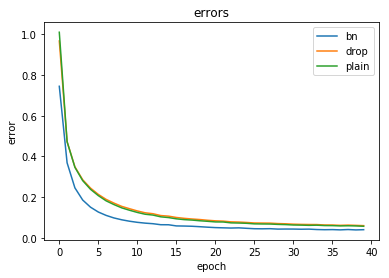

In [11]:
plot_graphs(test_log, 'loss')

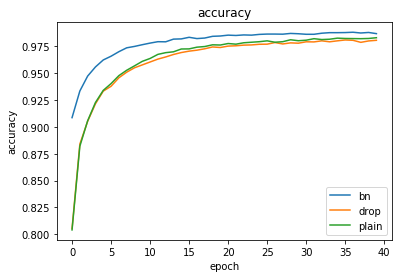

In [12]:
plot_graphs(test_log, 'accuracy')